In [1]:
from pathlib import Path

import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import geojsonio
import spectra

DATA_DIR = Path('../data')
%matplotlib inline

# Problem 2

In [2]:
# Load Auckland roads

path = DATA_DIR/'auckland_new-zealand_roads_gen1.geojson'
roads = gpd.read_file(str(path))
roads['osm_id'] = roads['osm_id'].astype(int).astype(str)
roads.head()

,access,bridge,class,geometry,name,oneway,osm_id,ref,service,tunnel,type,z_order
0,None,0,highway,LINESTRING (174.885374754468 -36.9925097039147...,Redoubt Road,1,4077492,None,None,0,secondary,5.0
1,None,0,highway,LINESTRING (174.7825679460168 -36.926756607184...,Neilson Street,0,4077500,None,None,0,primary,6.0
2,None,0,highway,LINESTRING (174.8133010321928 -36.920145632513...,Church Street,0,4077501,10,None,0,primary,6.0
3,yes,0,highway,LINESTRING (174.7635943347171 -36.858437809893...,Grafton Bridge,0,4279302,None,None,0,secondary,5.0
4,None,0,highway,LINESTRING (174.7613962644289 -36.857914276220...,Upper Queen Street,0,4279661,4,None,0,secondary,5.0


In [3]:
path = Path('roads.geojson')
geo = roads.to_json()
with path.open('w') as tgt:
    tgt.write(geo)


In [4]:
# Convert to NZTM projection 

print(roads.crs)
CRS_WGS84 = roads.crs
roads = roads.to_crs(epsg=2193)
print(roads.crs)
CRS_NZTM = roads.crs
roads.head()

{'init': 'epsg:4326'}
{'init': 'epsg:2193', 'no_defs': True}


,access,bridge,class,geometry,name,oneway,osm_id,ref,service,tunnel,type,z_order
0,None,0,highway,LINESTRING (1767778.116978053 5904297.21402450...,Redoubt Road,1,4077492,None,None,0,secondary,5.0
1,None,0,highway,LINESTRING (1758765.076053659 5911768.63763862...,Neilson Street,0,4077500,None,None,0,primary,6.0
2,None,0,highway,LINESTRING (1761516.533885194 5912450.48134130...,Church Street,0,4077501,10,None,0,primary,6.0
3,yes,0,highway,LINESTRING (1757215.13659337 5919379.770159338...,Grafton Bridge,0,4279302,None,None,0,secondary,5.0
4,None,0,highway,LINESTRING (1757020.244158367 5919441.47088102...,Upper Queen Street,0,4279661,4,None,0,secondary,5.0


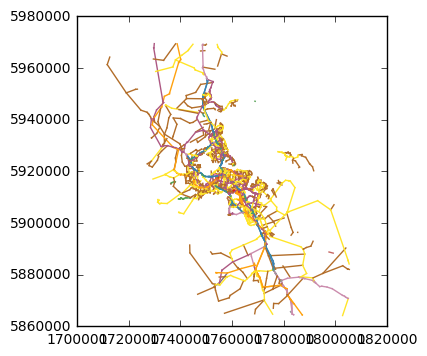

In [5]:
roads.plot(column='type')

# Problem 3

In [6]:
# Load NZ crashes 

path = DATA_DIR/'nz_crashes_2011--2016.csv'
crashes = pd.read_csv(path)
crashes.head().T

,0,1,2,3,4
CRASH_YEAR,2011,2011,2011,2011,2011
CRASH_SEV,F,F,F,F,F
fatal_count,1,1,1,1,2
seriousinj_count,1,1,1,1,0
minorinj_count,4,4,0,0,0
MULTI_VEH,Multi vehicle,Multi vehicle,Multi vehicle,Single vehicle,Multi vehicle
HOLIDAY,Christmas/New Year,Christmas/New Year,Christmas/New Year,Christmas/New Year,None
lg_region,Bay of Plenty,Waikato,Waikato,Auckland,Bay of Plenty
TLA_ID,27,13,11,7,23
TLA_NAME,Opotiki District,Waikato District,Thames-Coromandel District,Auckland,Tauranga City


In [7]:
# Filter crashes to Auckland region, 
# filter to those involving pedestrians or cyclists,
# and drop those with bad locations

f = crashes.copy()
cond = f['lg_region'] == 'Auckland'
#cond &= f['MULTI_VEH'].str.contains(r'cyclist|pedestrian', case=False)
cond &= (f['EASTING'] > 0) & (f['NORTHING'] > 0)
f = f[cond].copy()

# Convert to geodataframe in NZTM

geometry = [Point(p) for p in zip(f['EASTING'], f['NORTHING'])]
crashes = gpd.GeoDataFrame(f, crs=CRS_NZTM, geometry=geometry)
print(crashes.crs)
crashes.T

{'init': 'epsg:2193', 'no_defs': True}


,3,5,13,15,16,20,21,25,27,28,...,49930,49937,49944,49963,49965,49966,49977,49978,49982,49983
CRASH_YEAR,2011,2011,2011,2011,2011,2011,2011,2011,2011,2011,...,2016,2016,2016,2016,2016,2016,2016,2016,2016,2016
CRASH_SEV,F,F,F,F,F,F,F,F,F,F,...,M,S,S,M,S,M,S,M,M,M
fatal_count,1,1,1,1,1,1,1,2,1,2,...,0,0,0,0,0,0,0,0,0,0
seriousinj_count,1,1,0,0,0,0,0,0,0,4,...,0,1,1,0,1,0,1,0,0,0
minorinj_count,0,0,1,0,0,0,0,0,0,0,...,1,1,0,1,0,2,0,1,1,1
MULTI_VEH,Single vehicle,Multi vehicle,Multi vehicle,Multi vehicle,Multi vehicle,Vehicle(s)+Pedestrian(s),Single vehicle,Single vehicle,Single vehicle,Multi vehicle,...,Multi vehicle,Multi vehicle,Vehicle(s)+Pedestrian(s),Single vehicle,Vehicle(s)+Pedestrian(s),Single vehicle,Multi vehicle,Multi vehicle,Multi vehicle,Multi vehicle
HOLIDAY,Christmas/New Year,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,Easter,None,None,None,Christmas/New Year
lg_region,Auckland,Auckland,Auckland,Auckland,Auckland,Auckland,Auckland,Auckland,Auckland,Auckland,...,Auckland,Auckland,Auckland,Auckland,Auckland,Auckland,Auckland,Auckland,Auckland,Auckland
TLA_ID,7,7,7,7,7,7,7,7,7,7,...,7,7,7,7,7,7,7,7,7,7
TLA_NAME,Auckland,Auckland,Auckland,Auckland,Auckland,Auckland,Auckland,Auckland,Auckland,Auckland,...,Auckland,Auckland,Auckland,Auckland,Auckland,Auckland,Auckland,Auckland,Auckland,Auckland


In [8]:
path = Path('crashes.geojson')
geo = crashes.to_crs(CRS_WGS84).to_json()
with path.open('w') as tgt:
    tgt.write(geo)
#geojsonio.display(geo)

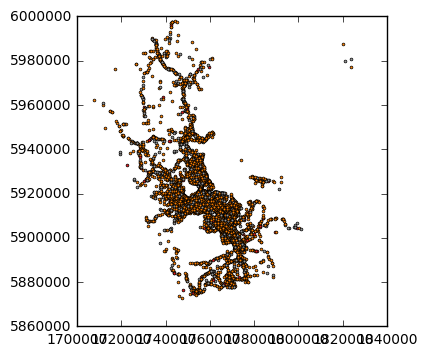

In [10]:
crashes.plot(column='CRASH_SEV')

# Problem 4

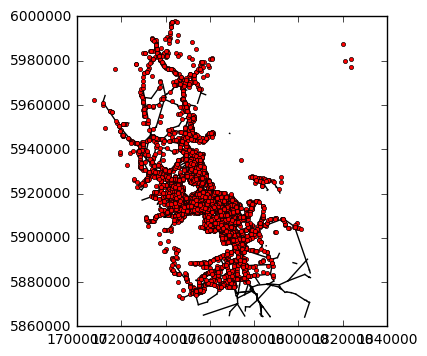

In [11]:
# Plot crashes on roads

base = roads.plot(color='black')
crashes.plot(ax=base, marker='o', color='red', markersize=3)

# Problem 5

In [12]:
# Spatial-join roads and buffered crash points

r = roads[['geometry', 'osm_id', 'name', 'class']]
c = crashes[['geometry', 'CRASH_SEV']].copy()
c['geometry'] = c['geometry'].buffer(20)
f = gpd.sjoin(r, c, how='inner')
f

,geometry,osm_id,name,class,index_right,CRASH_SEV,num_crashes,crash_score
0,LINESTRING (1767778.116978053 5904297.21402450...,4077492,Redoubt Road,highway,22808,M,1,1
1255,LINESTRING (1767784.564832801 5904278.00512419...,29417960,Manukau Station Road,highway,22808,M,1,1
2283,LINESTRING (1767791.477600971 5903962.81922155...,77350008,Great South Road,highway,22808,M,1,1
2320,LINESTRING (1767979.890629536 5904329.84242963...,79605480,Redoubt Road,highway,22808,M,1,1
3845,LINESTRING (1767637.767513235 5904283.68400765...,150576644,Manukau Station Road,highway,22808,M,1,1
3878,LINESTRING (1767587.805189282 5904627.71478708...,150701358,Great South Road,highway,22808,M,1,1
0,LINESTRING (1767778.116978053 5904297.21402450...,4077492,Redoubt Road,highway,30690,M,1,1
1255,LINESTRING (1767784.564832801 5904278.00512419...,29417960,Manukau Station Road,highway,30690,M,1,1
2283,LINESTRING (1767791.477600971 5903962.81922155...,77350008,Great South Road,highway,30690,M,1,1
2320,LINESTRING (1767979.890629536 5904329.84242963...,79605480,Redoubt Road,highway,30690,M,1,1


In [13]:
f['num_crashes'] = 1
s = {'M': 1, 'S': 2, 'F': 3}
f['crash_score'] = f['CRASH_SEV'].map(s)

g = f.groupby('osm_id').agg({
    'geometry': 'first', 
    'name': 'first', 
    'class': 'first',
    'num_crashes': 'sum',
    'crash_score': 'sum',
    }).reset_index()
g = g.rename(columns={'CRASH_SEV': 'num_crashes'})
g = gpd.GeoDataFrame(g, crs=CRS_NZTM)  # Lost the geodataframe during the groupby
# g['length'] = g['geometry'].length
# g['num_crashes/length'] = g['num_crashes']/g['length']
g = g.sort_values('crash_score', ascending=False)
crashy_roads = g.copy()
g

,osm_id,class,crash_score,geometry,num_crashes,name
1259,162165974,highway,75,LINESTRING (1756058.240467998 5917451.82949647...,63,Dominion Road
1548,204746291,highway,70,LINESTRING (1755983.430656193 5923043.83318007...,69,Auckland Harbour Bridge
3799,77452180,highway,69,LINESTRING (1755360.665057854 5921944.80412395...,68,Auckland Harbour Bridge
2074,28356105,highway,45,LINESTRING (1757658.307867997 5918337.94896551...,41,Auckland Southern Motorway
3840,79608439,highway,43,LINESTRING (1755983.124330193 5928063.73212330...,40,Auckland Northern Motorway
291,119983823,highway,43,LINESTRING (1756674.978098687 5926632.45171095...,40,Auckland Northern Motorway
211,118881476,highway,39,LINESTRING (1759844.447857592 5916140.09220145...,38,Auckland Southern Motorway
3480,52728801,highway,38,LINESTRING (1757215.13659337 5919379.770159338...,34,Symonds Street
1453,189294955,highway,37,LINESTRING (1759880.511084779 5915762.59836735...,35,Great South Road
3052,4279733,highway,37,LINESTRING (1756679.408218388 5919913.80535120...,32,Nelson Street


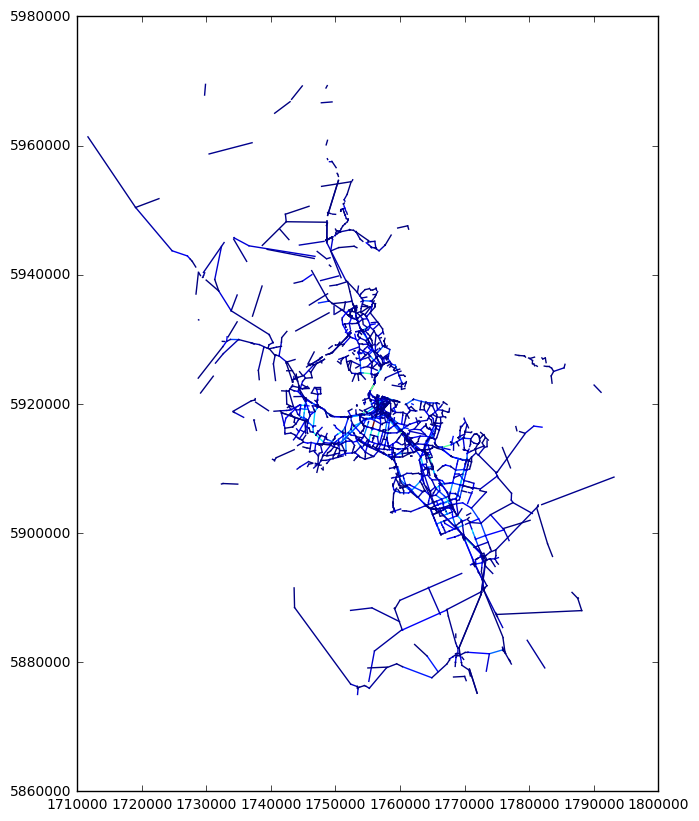

In [14]:
crashy_roads.plot(column='crash_score', figsize=(10, 10))

In [15]:
# Color and thickness code roads by number of crashes using Spectra.
# Export to GeoJSON and plot in geojsonio for a closer look

scale = spectra.scale(['#2b83ba', '#ffffbf', '#d7191c']).colorspace('lch')
m = crashy_roads['crash_score'].max()
crashy_roads['stroke'] = crashy_roads['crash_score'].map(
  lambda x: scale(x/m).hexcode)
crashy_roads['stroke-width'] = crashy_roads['crash_score']
geo = crashy_roads.to_crs(CRS_WGS84).to_json()
geojsonio.display(geo)

'http://geojson.io/#id=gist:/cd23c0edce86657fd6b4527ed3551105'